In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder,StandardScaler

import warnings
warnings.filterwarnings('ignore')

from glob import glob
from pathlib import Path
import joblib
import pickle
import os
import random

import time
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Load Dataset**

In [2]:
train             = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test              = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks            = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
submission_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

In [3]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


**EDA**

In [4]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first quartile'] = desc.loc[:, '25%'].values
    summ['second quartile'] = desc.loc[:, '50%'].values
    summ['third quartile'] = desc.loc[:, '75%'].values
    
    return summ

In [5]:
summary(train)

data shape: (617, 58)


,data type,#missing,%missing,#unique,min,max,first quartile,second quartile,third quartile
Id,object,0,0.000000,617,NaN,NaN,NaN,NaN,NaN
AB,float64,0,0.000000,217,0.081187,6.161666,0.252107,0.354659,0.559763
AF,float64,0,0.000000,599,192.59328,28688.18766,2197.34548,3120.31896,4361.63739
AH,float64,0,0.000000,227,85.200147,1910.123198,85.200147,85.200147,113.73954
AM,float64,0,0.000000,605,3.177522,630.51823,12.270314,20.53311,39.139886
AR,float64,0,0.000000,130,8.138688,178.943634,8.138688,8.138688,8.138688
AX,float64,0,0.000000,427,0.699861,38.27088,4.128294,5.031912,6.431634
AY,float64,0,0.000000,148,0.025578,10.315851,0.025578,0.025578,0.036845
AZ,float64,0,0.000000,484,3.396778,38.971568,8.12958,10.46132,12.969516
BC,float64,0,0.000000,259,1.2299,1463.693448,1.2299,1.2299,5.081244


* There are 56 X variables and 1 target(y) variable, while 1 variable(id) is not relevant for modelling

* All variable types are float64, except for the EJ variable which is of type object.
 
* 9 variables have missing value. The missing value ratio is not very high.

In [6]:
# select numerical and categorical variables respectively.
num_cols = test.select_dtypes(include=['float64']).columns.tolist()
cat_cols = test.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Id')

**Inspecting the class imbalance**

In [7]:
fig2 = px.pie(train, names='Class', 
             height=400, width=600, 
             hole=0.7, 
             title='Target Class Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

The dataset is quite imbalanced. Maybe need to try a few over-sampling methods like **SMOTE** in future versions

**Distribution of numerical variables**

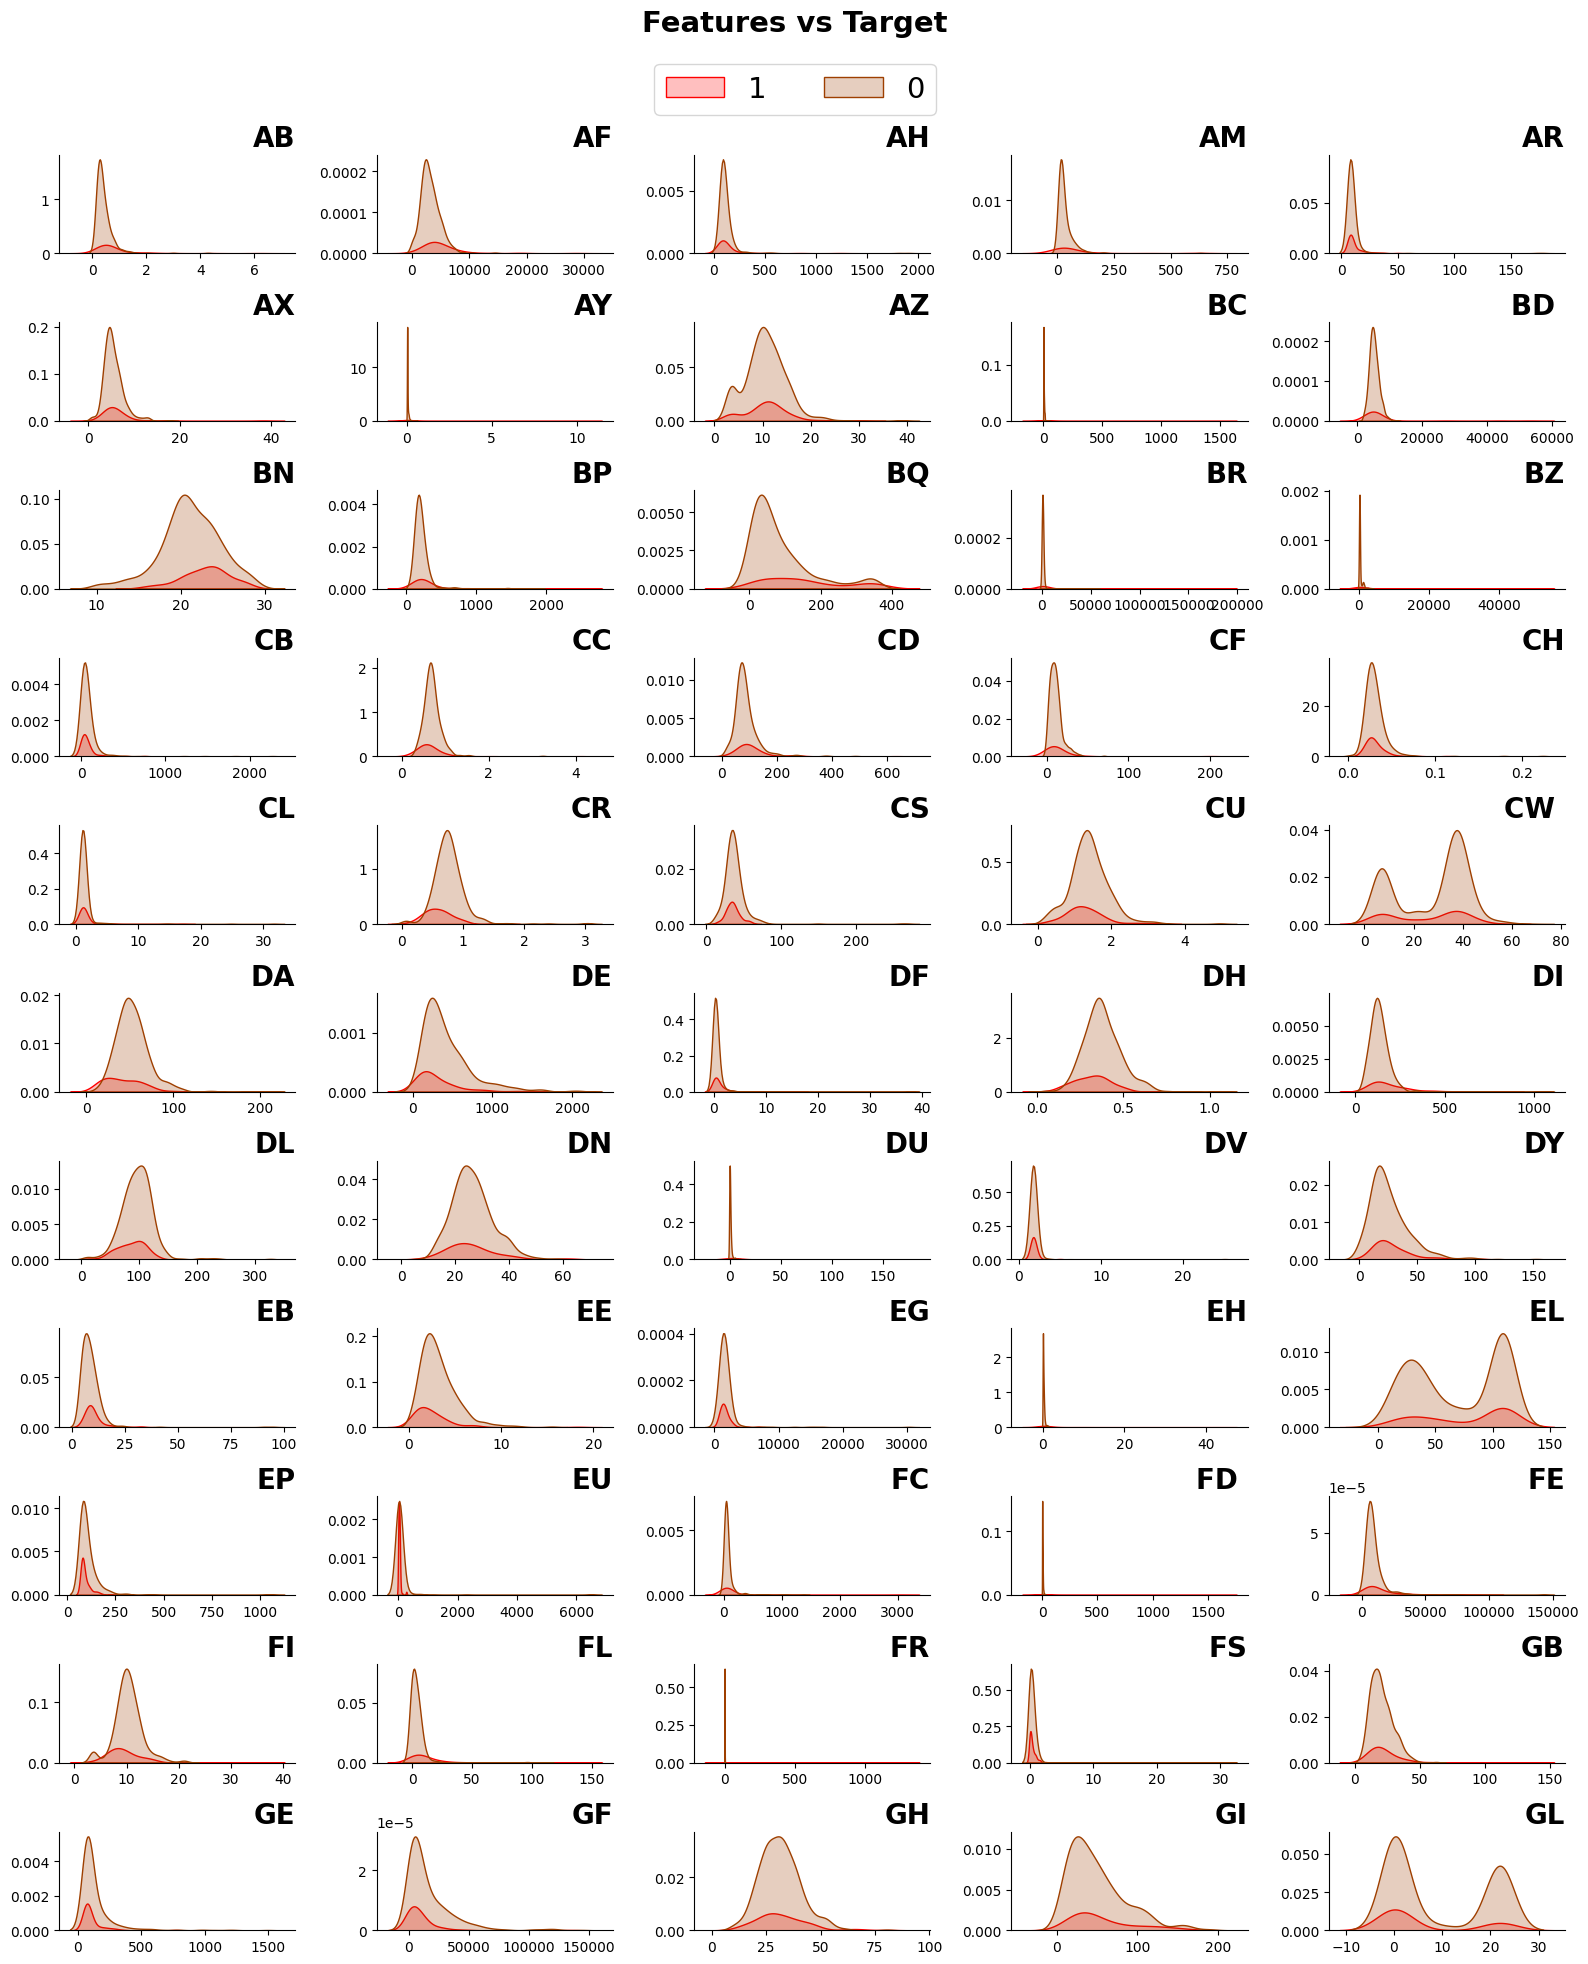

In [8]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols):
    ax = plt.subplot(11,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

* The distribution is different for most of the numerical variables, which means these variables have predictive power in some sense.

* Although, scaling might be required as they pertain to different scales

**Correlation heatmap for numerical variables**

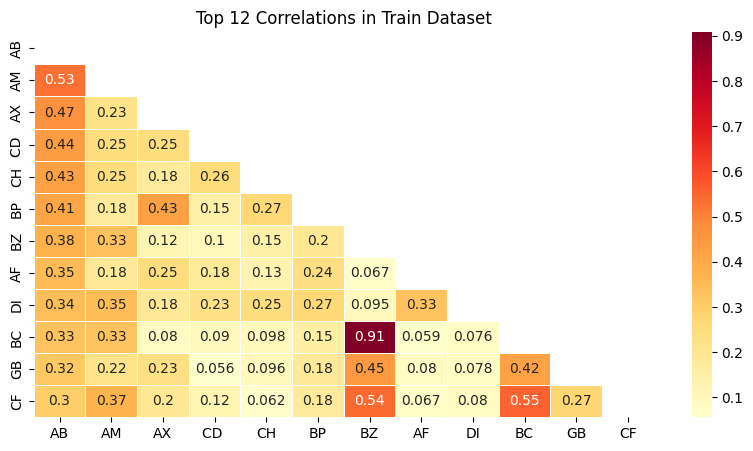

In [9]:
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str='Top Correlations') -> None:
    # Calculate correlation between all variables
    corr = df.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data
plot_top_correlations(train[num_cols], 12, 'Top 12 Correlations in Train Dataset')

Among the top-12 highly correlated numerical variables, although certain variables exhibit strong correlations, the overall correlation among the variables is not very high. This is especially considering that all the variables are health-related data.

**Model training using XGB, LightGBM, CatBoost**

In [10]:
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier

In [11]:
class CFG:
    VER = 1
    AUTHOR = 'maverick'
    COMPETITION = 'icr-identify-age-related-conditions'
    DATA_PATH = Path('/kaggle/input/icr-identify-age-related-conditions')
    OOF_DATA_PATH = Path('./oof')
    MODEL_DATA_PATH = Path('./models')
    METHOD_LIST = ['lightgbm', 'xgboost', 'catboost']
    seed = 3407 #52
    n_folds = 10 #replaced 20
    target_col = 'Class'
    metric = 'balanced_log_loss'
    metric_maximize_flag = False
    num_boost_round = 50500
    early_stopping_round = 500
    verbose = 2000
    boosting_type = 'dart'
    lgb_params = {
        'objective': 'binary', # 'binary', 'multiclass'
        'metric': None, # 'auc', 'multi_logloss'
        # 'num_class': None,
        'boosting': boosting_type,
        'device_type':'gpu',
        'learning_rate': 0.005,
        'num_leaves': 5,
        'feature_fraction': 0.50,
        'bagging_fraction': 0.80,
        'lambda_l1': 2, 
        'lambda_l2': 4,
        'n_jobs': -1,
        'is_unbalance':True, #added balancing
        'verbose': -1, #added silence
        # 'min_data_in_leaf': 40,
        # 'bagging_freq': 10,
        'seed': seed,
    }
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.005, 
        'max_depth': 4,
        'colsample_bytree': 0.50,
        'subsample': 0.80,
        'eta': 0.03,
        'gamma': 1.5,
        # 'lambda': 70,
        # 'min_child_weight': 8,
        # 'eval_metric':'logloss',
        # 'tree_method': 'gpu_hist',
        # 'predictor':'gpu_predictor',
        'random_state': seed,
    }
    
    cat_params = {
        'learning_rate': 0.005, 
        'iterations': num_boost_round, 
        'depth': 4, # 
        'colsample_bylevel': 0.50,
        'subsample': 0.80,
        'l2_leaf_reg': 3, # 3, 30
        'random_seed': seed,
        'auto_class_weights': 'Balanced'
        # 'task_type':'GPU', 
    }

In [12]:
!mkdir oof
!mkdir models

In [13]:
test[CFG.target_col] = -1
all_df = pd.concat([train, test])

**Setting Seed**

In [14]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

**Metric Calculation**

In [15]:
def balanced_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

# ====================================================
# LightGBM Metric
# ====================================================
def lgb_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), CFG.metric_maximize_flag

def xgb_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred)

# ====================================================
# Catboost Metric
# ====================================================
class CatboostMetric(object):
    def get_final_error(self, error, weight): return error
    def is_max_optimal(self): return CFG.metric_maximize_flag
    def evaluate(self, approxes, target, weight):
        error = balanced_log_loss(np.array(target), approxes)
        return error, 0

In [16]:
def calc_log_loss_weight(y_true):
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

def lightgbm_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    lgb_train = lgb.Dataset(x_train, y_train, weight=y_train.map({0: train_w0, 1: train_w1}), categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(x_valid, y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}), categorical_feature=categorical_features)
    model = lgb.train(
                params = CFG.lgb_params,
                train_set = lgb_train,
                num_boost_round = CFG.num_boost_round,
                valid_sets = [lgb_train, lgb_valid],
                early_stopping_rounds = CFG.early_stopping_round,
                verbose_eval = CFG.verbose,
                # feval = lgb_metric,
            )
    # Predict validation
    valid_pred = model.predict(x_valid)
    return model, valid_pred
def xgboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    xgb_train = xgb.DMatrix(data=x_train, label=y_train, weight=y_train.map({0: train_w0, 1: train_w1}))
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}))
    model = xgb.train(
                CFG.xgb_params, 
                dtrain = xgb_train, 
                num_boost_round = CFG.num_boost_round, 
                evals = [(xgb_train, 'train'), (xgb_valid, 'eval')], 
                early_stopping_rounds = CFG.early_stopping_round, 
                verbose_eval = CFG.verbose,
                # feval = xgb_metric, 
                # maximize = CFG.metric_maximize_flag, 
            )
    # Predict validation
    valid_pred = model.predict(xgb.DMatrix(x_valid), iteration_range=(0, model.best_ntree_limit))
    return model, valid_pred
    
def catboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    cat_train = Pool(data=x_train, label=y_train, weight=y_train.map({0: train_w0, 1: train_w1}), cat_features=categorical_features)
    cat_valid = Pool(data=x_valid, label=y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}), cat_features=categorical_features)
    model = CatBoostClassifier(**CFG.cat_params) # , eval_metric = CatboostMetric
    model.fit(cat_train, 
              eval_set=[cat_valid],
              early_stopping_rounds=CFG.early_stopping_round, 
              verbose=CFG.verbose, 
              use_best_model=True)
    # Predict validation
    valid_pred = model.predict_proba(x_valid)[:, 1]
    return model, valid_pred

def gradient_boosting_model_cv_training(method: str, train_df: pd.DataFrame, features: list, categorical_features: list):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train_df))
    oof_fold = np.zeros(len(train_df))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (train_index, valid_index) in enumerate(kfold.split(train_df, train_df[CFG.target_col])):
        print('-'*50)
        print(f'{method} training fold {fold + 1}')
        
        x_train = train_df[features].iloc[train_index]
        y_train = train_df[CFG.target_col].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_valid = train_df[CFG.target_col].iloc[valid_index]
        if method == 'lightgbm':
            model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        if method == 'xgboost':
            model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        if method == 'catboost':
            model, valid_pred = catboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        
        # Save best model
        pickle.dump(model, open(CFG.MODEL_DATA_PATH / f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'wb'))
        # Add to out of folds array
        oof_predictions[valid_index] = valid_pred
        oof_fold[valid_index] = fold + 1
        del x_train, x_valid, y_train, y_valid, model, valid_pred
        gc.collect()

    # Compute out of folds metric
    score = balanced_log_loss(train_df[CFG.target_col], oof_predictions)
    print(f'{method} our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'Id': train_df['Id'], CFG.target_col: train_df[CFG.target_col], f'{method}_prediction': oof_predictions, 'fold': oof_fold})
    oof_df.to_csv(CFG.MODEL_DATA_PATH / f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv', index = False)

**Feature Selection**

In [17]:
numerical_features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', #'BC', 
                      'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ',
                      'CB', 'CC', 'CD', 'CF', 'CH', #'CL', 
                      'CR', 'CS', 'CU', 'CW',
                      'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
                      'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU',
                      'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS',
                      'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
categorical_features = ['EJ']
features = numerical_features + categorical_features
str2int_dict = {}
str2int_dict['EJ'] = {'A': 1, 'B': 0}
seed_everything(CFG.seed)

**Preprocessing**

In [18]:
def Preprocessing(input_df: pd.DataFrame)->pd.DataFrame:
    input_df = input_df.rename(columns={'BD ': 'BD', 'CD ': 'CD', 'CW ': 'CW', 'FD ': 'FD'}) #?
    output_df = input_df.copy()
    sc = StandardScaler()
    output_df[numerical_features] = sc.fit_transform(output_df[numerical_features]) #added scaling
    for col in categorical_features:
        output_df[col] = input_df[col].map(str2int_dict[col])
    return output_df
all_df = Preprocessing(all_df)

In [19]:
train_df = all_df[all_df[CFG.target_col] != -1].copy()
test_df = all_df[all_df[CFG.target_col] == -1].copy()

In [20]:
for method in CFG.METHOD_LIST:
    gradient_boosting_model_cv_training(method, train_df, features, categorical_features)

--------------------------------------------------
lightgbm training fold 1
[2000]	training's binary_logloss: 0.240573	valid_1's binary_logloss: 0.380607
[4000]	training's binary_logloss: 0.133936	valid_1's binary_logloss: 0.33575
[6000]	training's binary_logloss: 0.083121	valid_1's binary_logloss: 0.313387
[8000]	training's binary_logloss: 0.0549198	valid_1's binary_logloss: 0.311153
[10000]	training's binary_logloss: 0.0411957	valid_1's binary_logloss: 0.323623
[12000]	training's binary_logloss: 0.0319705	valid_1's binary_logloss: 0.333704
[14000]	training's binary_logloss: 0.0269473	valid_1's binary_logloss: 0.343833
[16000]	training's binary_logloss: 0.0230827	valid_1's binary_logloss: 0.352814
[18000]	training's binary_logloss: 0.020925	valid_1's binary_logloss: 0.358793
[20000]	training's binary_logloss: 0.0193932	valid_1's binary_logloss: 0.363868
[22000]	training's binary_logloss: 0.0181028	valid_1's binary_logloss: 0.365713
[24000]	training's binary_logloss: 0.0172531	valid_1'

**Inference**

In [21]:
def lightgbm_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds
def xgboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        test_pred += model.predict(xgb.DMatrix(x_test), iteration_range=(0, model.best_ntree_limit))
    return test_pred / CFG.n_folds
    
def catboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'catboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        test_pred += model.predict_proba(x_test)[:, 1]
    return test_pred / CFG.n_folds

def gradient_boosting_model_inference(method: str, test_df: pd.DataFrame, features: list, categorical_features: list):
    x_test = test_df[features]
    if method == 'lightgbm':
        test_pred = lightgbm_inference(x_test)
    if method == 'xgboost':
        test_pred = xgboost_inference(x_test)
    if method == 'catboost':
        test_pred = catboost_inference(x_test)
    return test_pred

In [22]:
for method in CFG.METHOD_LIST:
    test_df[f'{method}_pred_prob'] = gradient_boosting_model_inference(method, test_df, features, categorical_features)
    train_df[f'{method}_pred_prob'] = gradient_boosting_model_inference(method, train_df, features, categorical_features)

In [23]:
from scipy.optimize import minimize

predictions = []
for method in CFG.METHOD_LIST:
    predictions.append(gradient_boosting_model_inference(method, train_df, features, categorical_features))

In [24]:
print(len(predictions))
print(len(predictions[0]))

3
617


In [25]:
def mse_func(weights):
    #scipy minimize will pass the weights as a numpy array
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction
    #return np.mean((y_test-final_prediction)**2)
    return balanced_log_loss(train['Class'], final_prediction)
    
num_predictions = len(predictions)
starting_values = [1 / num_predictions] * num_predictions

cons = ({'type':'ineq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)

res = minimize(mse_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

print('Ensamble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Ensamble Score: 0.02184406636599086
Best Weights: [1.00000000e+00 8.42817748e-16 8.18789481e-16]


**submission**

In [26]:
test_df['class_1'] = 1 * test_df['lightgbm_pred_prob'] + 0.0 * test_df['xgboost_pred_prob'] + 0.0 * test_df['catboost_pred_prob']
test_df['class_0'] = 1 - test_df['class_1']
test_df[list(submission_df)].to_csv('submission.csv', index=False)

In [27]:
test_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,lightgbm_pred_prob,xgboost_pred_prob,catboost_pred_prob,class_1,class_0
0,00eed32682bb,-1.011209,-1.503536,-0.921745,-0.556365,-0.956201,-2.126241,-0.144237,-2.365371,0.0,...,-0.754332,-3.059007,-1.379554,-0.821162,-1,0.381337,0.191424,0.142994,0.381337,0.618663
1,010ebe33f668,-1.011209,-1.503536,-0.921745,-0.556365,-0.956201,-2.126241,-0.144237,-2.365371,0.0,...,-0.754332,-3.059007,-1.379554,-0.821162,-1,0.381337,0.191424,0.142994,0.381337,0.618663
2,02fa521e1838,-1.011209,-1.503536,-0.921745,-0.556365,-0.956201,-2.126241,-0.144237,-2.365371,0.0,...,-0.754332,-3.059007,-1.379554,-0.821162,-1,0.381337,0.191424,0.142994,0.381337,0.618663
3,040e15f562a2,-1.011209,-1.503536,-0.921745,-0.556365,-0.956201,-2.126241,-0.144237,-2.365371,0.0,...,-0.754332,-3.059007,-1.379554,-0.821162,-1,0.381337,0.191424,0.142994,0.381337,0.618663
4,046e85c7cc7f,-1.011209,-1.503536,-0.921745,-0.556365,-0.956201,-2.126241,-0.144237,-2.365371,0.0,...,-0.754332,-3.059007,-1.379554,-0.821162,-1,0.381337,0.191424,0.142994,0.381337,0.618663


In [28]:
test_df[list(submission_df)]

,Id,class_0,class_1
0,00eed32682bb,0.618663,0.381337
1,010ebe33f668,0.618663,0.381337
2,02fa521e1838,0.618663,0.381337
3,040e15f562a2,0.618663,0.381337
4,046e85c7cc7f,0.618663,0.381337
